In [1]:
import os
import csv
import shutil
import random

Wycinamy spektrogram, żeby do modelu trafiła ta część obrazka, która ma znaczenie

In [ ]:
from PIL import Image
training_directory = "daps_Data\\Spectrograms_mel_16_normalized"
left = 125
top = 60
right = 901
bottom = 446
target = "daps_Data\\Spectrograms_mel_16_normalized_cropped_training\\Images\\"
# Opens a image in RGB mode
for filename in os.listdir(training_directory):
    fullpath = os.path.join(training_directory, filename)
    im = Image.open(fullpath)
# Cropped image of above dimension
# (It will not change original image)
    im1 = im.crop((left, top, right, bottom))
    im1.save(target + filename)

Tworzymy plik csv opisujący, do której klasy należy spektrogram.

In [22]:
# name of csv file
csvname = "daps_Data\\training_dataset\\labels.csv"
class_one_indicators = ['f1', 'f7', 'f8', 'm3', 'm6', 'm8']
directory = "daps_Data\\training_dataset\\images"
# writing to csv file
with open(csvname, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
    for filename in os.listdir(directory):
        if any(indicator in filename for indicator in class_one_indicators) and not 'f10' in filename:
            csvwriter.writerow([filename, '1'])
        else:
            csvwriter.writerow([filename, '0'])        

In [1]:
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torchvision
import torchvision.transforms.v2
import torchvision.transforms as transforms

Tworzymy klasę dla customowego datasetu

In [2]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Stworzenie naszych datasetów

In [5]:
transform = torchvision.transforms.v2.Compose([transforms.Resize((96, 194)),transforms.v2.ToImage(),\
                                               transforms.v2.ToDtype(torch.float32, scale=True),\
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = ImageDataset(annotations_file = "..\\work_folder\\daps_Data\\Spectrograms_mel_16_normalized_cropped_training\\labels.csv", img_dir = "..\\work_folder\\daps_Data\\Spectrograms_mel_16_normalized_cropped_training\\Images"\
                       , transform = transform)

testset = ImageDataset(annotations_file = "..\\work_folder\\daps_Data\\Spectrograms_mel_16_normalized_cropped_test\\labels.csv", img_dir = "..\\work_folder\\daps_Data\\Spectrograms_mel_16_normalized_cropped_test\\Images"\
                      , transform = transform)

In [6]:
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
classes = ("0", "1")

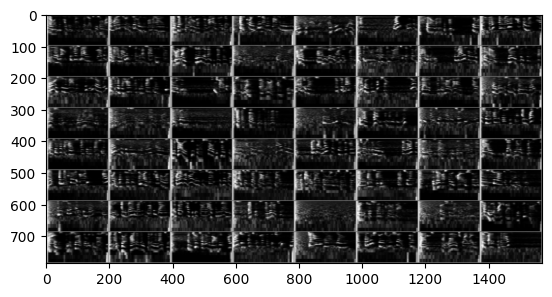

0     0     0     0     1     1     1     0     0     0     1     1     1     0     0     1     0     0     0     1     0     0     0     1     0     0     0     0     0     1     0     0     0     0     0     1     1     0     0     0     0     0     1     0     0     0     0     0     0     0     0     0     0     0     0     1     1     0     1     0     0     1     0     1    


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Tworzenie sieci

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 64, 64)
            nn.BatchNorm2d(num_features = 32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 32, 32)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (N, 64, 32, 32)
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (N, 128, 16, 16)
            nn.BatchNorm2d(num_features = 128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (N, 128, 8, 8)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(36864, 256 * 4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

net = Net(num_classes=NUM_CLASSES).to(DEVICE)
print(net)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=36864, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(

Trenowanie modelu

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

In [10]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.4f}')
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 5.4696
[1,    20] loss: 0.7334
[1,    30] loss: 0.6446
[1,    40] loss: 0.6206
[1,    50] loss: 0.6309
[1,    60] loss: 0.6247
[1,    70] loss: 0.6488
[1,    80] loss: 0.6275
[1,    90] loss: 0.6323
[1,   100] loss: 0.6370
[1,   110] loss: 0.6252
[1,   120] loss: 0.6268
[1,   130] loss: 0.6268
[1,   140] loss: 0.6270
[1,   150] loss: 0.6192
[1,   160] loss: 0.6309
[1,   170] loss: 0.6442
[1,   180] loss: 0.6494
[1,   190] loss: 0.6279
[1,   200] loss: 0.6495
[1,   210] loss: 0.6502
[1,   220] loss: 0.6274
[1,   230] loss: 0.6050
[1,   240] loss: 0.5896
[1,   250] loss: 0.6441
[1,   260] loss: 0.6342
[1,   270] loss: 0.6467
[1,   280] loss: 0.6324
[1,   290] loss: 0.6034
[1,   300] loss: 0.6219
[1,   310] loss: 0.6293
[1,   320] loss: 0.6374
[1,   330] loss: 0.5982
[1,   340] loss: 0.6124
[1,   350] loss: 0.6410
[1,   360] loss: 0.6404
[1,   370] loss: 0.6274
[1,   380] loss: 0.6261
[1,   390] loss: 0.6356
[1,   400] loss: 0.6376
[1,   410] loss: 0.6320
[1,   420] loss:

In [11]:
PATH = '../work_folder/model_20.pth'

In [12]:
torch.save(net.state_dict(), PATH)

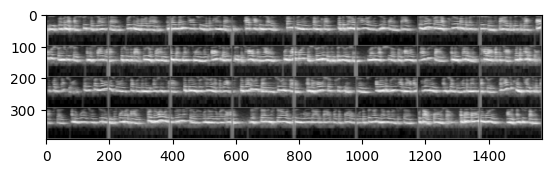

GroundTruth:  0     0     0     0    


In [32]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [13]:
net = Net(2)
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Testowanie naszego modelu

In [34]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  0     0     0     0    


In [35]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 test images: {100 * correct // total} %')

Accuracy of the network on the 1000 test images: 96 %


In [14]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f}%, {correct_count} out of {total_pred[classname]}')

Accuracy for class: 0     is 96.5%, 9806 out of 10166
Accuracy for class: 1     is 89.0%, 4050 out of 4549
